In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import download_url
from torchvision.transforms.v2 import ToImage, Resize, CenterCrop, Compose
from transformers import CLIPProcessor, CLIPModel
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, StableUnCLIPImg2ImgPipeline

from semantic_selective_classification import semantic_binning
from utils import ECE_calc

path_huggingface = os.path.expandvars('$DSDIR/HuggingFace_Models/') 
path_pretrained = Path(os.path.expandvars('$WORK/MODELS'))
path_sd = path_pretrained / 'stabilityai--stable-diffusion-2-1-base'


In [2]:
class CLIP_ZeroShot(nn.Module):
    def __init__(self, list_prompts):
        super().__init__()
        self.CLIP_model = CLIPModel.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14").cuda()
        self.CLIP_processor = CLIPProcessor.from_pretrained(path_huggingface+"openai/clip-vit-large-patch14")
        self.list_prompts = list_prompts

    def forward(self, images):
        with torch.no_grad():
            inputs = self.CLIP_processor(text=self.list_prompts, images=images, return_tensors="pt", padding=True)
            for name, tensor in inputs.items():
                inputs[name] = tensor.cuda()
            outputs = self.CLIP_model(**inputs)
        logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
        # probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities
        return logits_per_image

class CUB(Dataset):
    """from https://github.com/TDeVries/cub2011_dataset/blob/master/cub2011.py"""
    base_folder = 'CUB_200_2011/images'
    url = 'https://data.caltech.edu/records/65de6-vp158/files/CUB_200_2011.tgz'
    filename = 'CUB_200_2011.tgz'
    tgz_md5 = '97eceeb196236b17998738112f37df78'

    def __init__(self, root, train=True, transform=None, download=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.loader = default_loader
        self.train = train

        if download:
            self._download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

    def _load_metadata(self):
        images = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'images.txt'), sep=' ',
                             names=['img_id', 'filepath'])
        image_class_labels = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'image_class_labels.txt'),
                                         sep=' ', names=['img_id', 'target'])
        train_test_split = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'train_test_split.txt'),
                                       sep=' ', names=['img_id', 'is_training_img'])
        self.class_names = pd.read_csv(os.path.join(self.root, 'CUB_200_2011', 'classes.txt'), 
                                       usecols=[1], sep='.', header=None, dtype=str).iloc[:,0].str.replace('_', ' ').to_dict()

        data = images.merge(image_class_labels, on='img_id')
        self.data = data.merge(train_test_split, on='img_id')

        if self.train:
            self.data = self.data[self.data.is_training_img == 1]
        else:
            self.data = self.data[self.data.is_training_img == 0]

    def _check_integrity(self):
        try:
            self._load_metadata()
        except Exception:
            return False

        for index, row in self.data.iterrows():
            filepath = os.path.join(self.root, self.base_folder, row.filepath)
            if not os.path.isfile(filepath):
                print(filepath)
                return False
        return True

    def _download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        download_url(self.url, self.root, self.filename, self.tgz_md5)

        with tarfile.open(os.path.join(self.root, self.filename), "r:gz") as tar:
            tar.extractall(path=self.root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data.iloc[idx]
        path = os.path.join(self.root, self.base_folder, sample.filepath)
        target = sample.target - 1  # Targets start at 1 by default, so shift to 0
        img = self.loader(path)

        if self.transform is not None:
            img = self.transform(img)

        return img, target


batch_size = 256

train_dataset = CUB(root=os.path.expandvars('$SCRATCH'), transform=Compose([ToImage(), Resize(224), CenterCrop(224)]), train=True, download=True)
test_dataset = CUB(root=os.path.expandvars('$SCRATCH'), transform=Compose([ToImage(), Resize(224), CenterCrop(224)]), train=False, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

clip = CLIP_ZeroShot([f"A photo of a {class_name}." for class_name in list(test_dataset.class_names.values())])

attributes = {
    'background': ['in plants', 'on a branch', 'on the ground', 'on the water', 'in the sky'],
    'position': ['still', 'flying', 'swimming'],
    # 'color'
}
clip_background = CLIP_ZeroShot([f'A photo of a bird {a}.' for a in attributes["background"]])
clip_position = CLIP_ZeroShot([f'The bird is {a}.' for a in attributes["position"]])

Files already downloaded and verified
Files already downloaded and verified


In [3]:
fname = '../results/logs_CLIP.csv'

if os.path.exists(fname):
    df = pd.read_csv(fname)
else:
    df = pd.DataFrame(index=range(len(train_dataset)+len(test_dataset)), columns=['split', 'label', 'prediction', 'correct', 'max_logit', 'max_cosim', 'confidence', 'background_pred', 'position_pred'])
    idx = 0
    for split, dataloader in zip(['train', 'test'], [train_dataloader, test_dataloader]):
        for images, labels in dataloader:
            b_size = labels.shape[0]
            logits = clip(images).cpu()
            max_logits, predicted = logits.max(dim=1)
            max_probas = logits.softmax(dim=1).max(dim=1).values
            max_probas_2nd = torch.topk(logits.softmax(dim=1), k=2, dim=1).values[:,1]
            max_probas_3rd = torch.topk(logits.softmax(dim=1), k=3, dim=1).values[:,2]
            # background
            logits = clip_background(images).cpu()
            max_probas_back, predicted_back = logits.softmax(dim=1).max(dim=1)
            # position
            logits = clip_position(images).cpu()
            max_probas_pos, predicted_pos = logits.softmax(dim=1).max(dim=1)

            df.loc[idx:idx+b_size-1, 'split'] = split
            df.loc[idx:idx+b_size-1, 'label'] = labels.tolist()
            df.loc[idx:idx+b_size-1, 'prediction'] = predicted.tolist()
            df.loc[idx:idx+b_size-1, 'correct'] = (labels == predicted).tolist()
            df.loc[idx:idx+b_size-1, 'max_logit'] = max_logits.tolist()
            df.loc[idx:idx+b_size-1, 'max_cosim'] = (max_logits / clip.CLIP_model.logit_scale.exp().item()).tolist()
            df.loc[idx:idx+b_size-1, 'confidence'] = max_probas.tolist()
            df.loc[idx:idx+b_size-1, 'max_probability_2nd'] = max_probas_2nd.tolist()
            df.loc[idx:idx+b_size-1, 'max_probability_3rd'] = max_probas_3rd.tolist()
            df.loc[idx:idx+b_size-1, 'background_pred'] = [attributes["background"][p] for p in predicted_back]
            df.loc[idx:idx+b_size-1, 'background_proba'] = max_probas_back.tolist()
            df.loc[idx:idx+b_size-1, 'position_pred'] = [attributes["position"][p] for p in predicted_pos]
            df.loc[idx:idx+b_size-1, 'position_proba'] = max_probas_pos.tolist()
            idx += b_size

    df.to_csv(fname, index=False)

# value 'unknown' when proba is low
df.loc[df['background_proba'] < 0.4, 'background_pred'] = 'unknown'
df.loc[df['position_proba'] < 0.7, 'position_pred'] = 'unknown'

df_calib = df[df['split'] == 'train']
df_test = df[df['split'] == 'test']

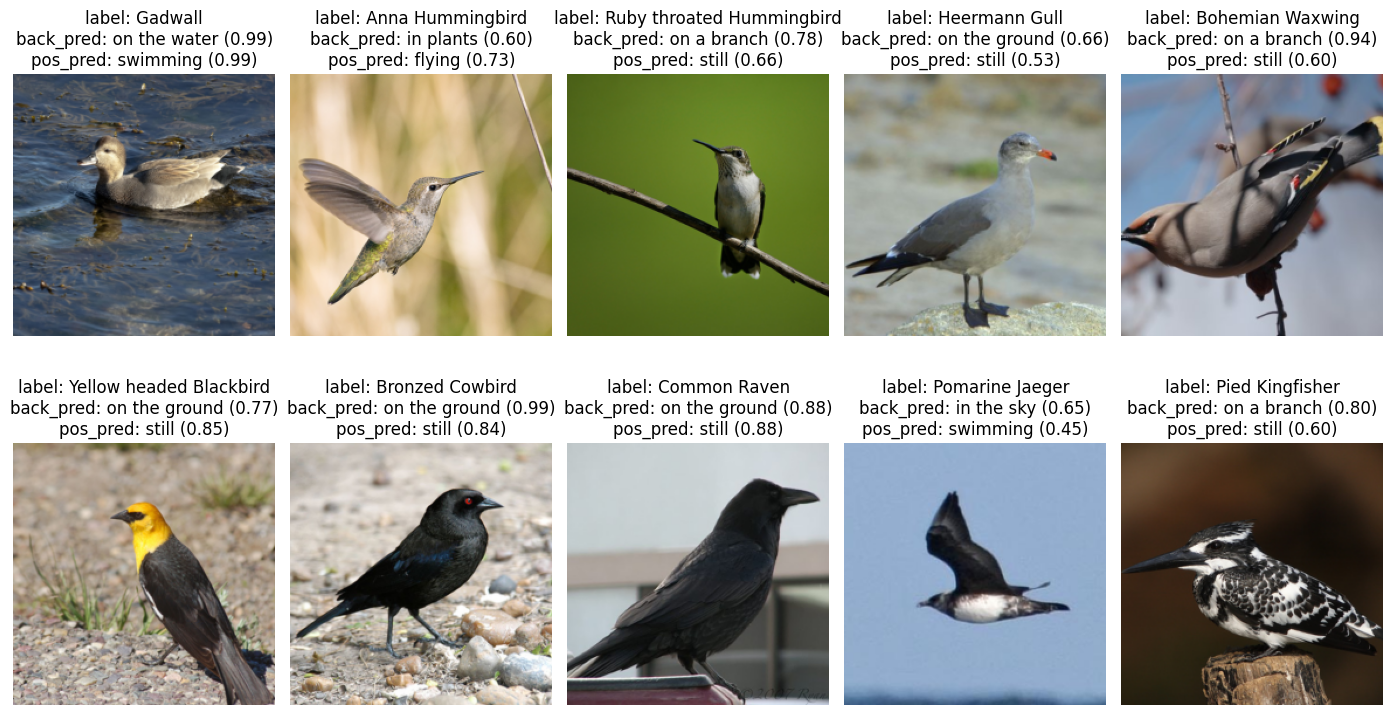

In [15]:
n_col = 5
n_row = 2
fig, axs = plt.subplots(n_row, n_col, figsize=(14, 8)) 

for i in range(n_col*n_row):
    random_index = np.random.randint(0, len(test_dataset) - 1)
    image, label = test_dataset[random_index]
    logit = clip_background(image).cpu()
    proba_back, predicted_back = logit.softmax(dim=1).max(dim=1)
    logit = clip_position(image).cpu()
    proba_pos, predicted_pos = logit.softmax(dim=1).max(dim=1)
    ax = axs[i // n_col, i % n_col]  # Determine the row and column
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f'label: {test_dataset.class_names[label]}\nback_pred: {attributes["background"][predicted_back]} ({proba_back.item():.2f})\npos_pred: {attributes["position"][predicted_pos]} ({proba_pos.item():.2f})')
    ax.axis('off')

plt.tight_layout()
plt.savefig('../results/CUB_CLIP_samples.pdf')

In [5]:
# Find confidence threshold for background prediction: 0.4 minimizes calib AUROC

# value 'unknown' when proba is low
for threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(threshold)
    df_calib_copy = df_calib.copy()
    df_calib_copy.loc[df_calib_copy['background_proba'] < threshold, 'background_pred'] = 'unknown'
    semantic_binning(df_calib_copy, df_calib_copy, ['background_pred'], df_test['prediction'].unique())

    # df_test_copy = df_test.copy()
    # df_test_copy.loc[df_test_copy['background_proba'] < threshold, 'background_pred'] = 'unknown'
    # semantic_binning(df_calib_copy, df_test_copy, ['background_pred'], df_test['prediction'].unique())

0
['background_pred']
6 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.542
ECE baseline: 0.029 ECE: 0.000

0.1
['background_pred']
6 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.542
ECE baseline: 0.029 ECE: 0.000

0.2
['background_pred']
6 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.542
ECE baseline: 0.029 ECE: 0.000

0.3
['background_pred']
6 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.542
ECE baseline: 0.029 ECE: 0.000

0.4
['backgrou

In [6]:
# value 'unknown' when proba is low: 0.7 minimizes calib AUROC
for threshold in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    print(threshold)
    df_calib_copy = df_calib.copy()
    df_calib_copy.loc[df_calib_copy['position_proba'] < threshold, 'position_pred'] = 'unknown'
    semantic_binning(df_calib_copy, df_calib_copy, ['position_pred'], df_test['prediction'].unique())

    # df_test_copy = df_test.copy()
    # df_test_copy.loc[df_test_copy['position_proba'] < threshold, 'position_pred'] = 'unknown'
    # semantic_binning(df_calib_copy, df_test_copy, ['position_pred'], df_test['prediction'].unique())

0
['position_pred']
4 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.528
ECE baseline: 0.029 ECE: 0.000

0.1
['position_pred']
4 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.528
ECE baseline: 0.029 ECE: 0.000

0.2
['position_pred']
4 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.528
ECE baseline: 0.029 ECE: 0.000

0.3
['position_pred']
4 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.807 AUROC subdomains: 0.528
ECE baseline: 0.029 ECE: 0.000

0.4
['position_pred']


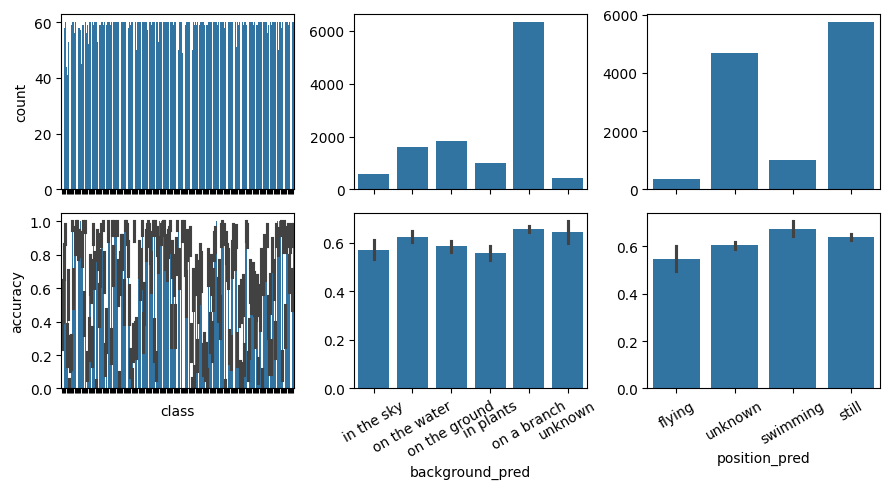

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(9, 5))
for i, attribute in enumerate(['label', 'background_pred', 'position_pred']):
    sns.countplot(df, x=attribute, ax=axs[0, i])
    axs[0, i].tick_params(axis='x', rotation=30)
    
    sns.barplot(df, x=attribute, y='correct', ax=axs[1, i])
    axs[1, i].tick_params(axis='x', rotation=30)

    if attribute == 'label':
        axs[1, i].xaxis.set_ticklabels([])
        axs[1, i].set_xlabel('class')
    axs[0, i].xaxis.set_ticklabels([])
    axs[0, i].set_xlabel('')
    axs[0, i].set_ylabel('')
    axs[1, i].set_ylabel('')
axs[0, 0].set_ylabel('count')
axs[1, 0].set_ylabel('accuracy')
plt.tight_layout()
plt.savefig('../results/CUB_CLIP_histo_acc_count.pdf', bbox_inches='tight')

# semantic selective classif

In [8]:
for subdomain_attributes in [
    ['prediction'], ['background_pred'], ['position_pred'],
    ['background_pred', 'position_pred'],
    ['prediction', 'position_pred'], 
    ['prediction', 'background_pred'], 
    ['prediction', 'background_pred', 'position_pred'], 
    ]:
    df_test = semantic_binning(df_calib, df_test, subdomain_attributes, df_test['prediction'].unique())

['prediction']
192 calib subdomains
13 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.


/gpfsdswork/projects/rech/dcf/ulb98yg/semantics/code/semantic_selective_classification.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[:, 'subdomain_score'] = None


AUROC baseline: 0.810 AUROC subdomains: 0.833
ECE baseline: 0.029 ECE: 0.020

['background_pred']
6 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.535
ECE baseline: 0.029 ECE: 0.002

['position_pred']
4 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.527
ECE baseline: 0.029 ECE: 0.002

['background_pred', 'position_pred']
23 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.551
ECE baseline: 0.029 ECE: 0.010

['prediction', 'position_pred']
371 calib subdomains
243 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted cla

['prediction']
192 calib subdomains
13 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.


AUROC baseline: 0.810 AUROC subdomains: 0.833
ECE baseline: 0.029 ECE: 0.020

['prediction', 'background_pred', 'position_pred']
545 calib subdomains
935 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.829
ECE baseline: 0.029 ECE: 0.031

['background_pred', 'position_pred']
23 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.551
ECE baseline: 0.029 ECE: 0.010

['background_pred']
6 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.535
ECE baseline: 0.029 ECE: 0.002

['position_pred']
4 calib subdomains
0 nan values (they appear because subdomains in test are not all included in train). Fallback to averag

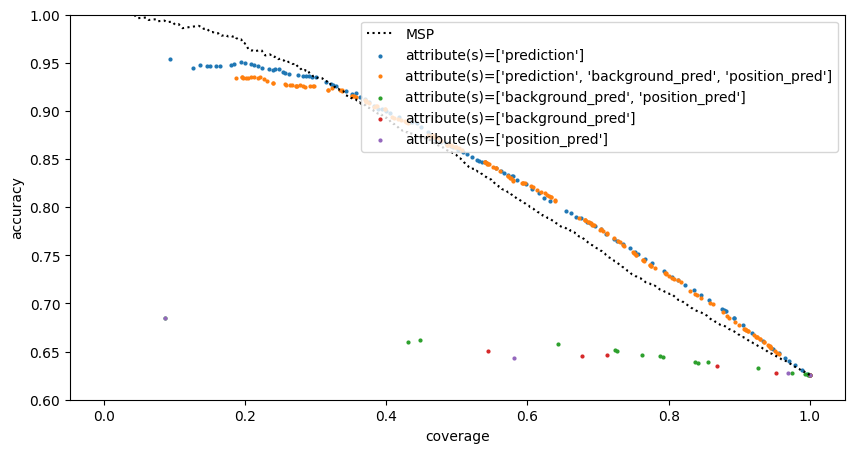

In [22]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(df_test['confidence'].min(), df_test['confidence'].max(), 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test.loc[idx_domain, 'correct'].mean()


domain_cutoff_oracle = np.linspace(0.01, 1, 100)
coverage_oracle = np.zeros_like(domain_cutoff_oracle)
acc_oracle = np.zeros_like(domain_cutoff_oracle)
for i, cut in enumerate(domain_cutoff_oracle):
    idx_domain = df_test.sort_values(by='correct', ascending=False).index[:int(cut*len(df_test))]
    coverage_oracle[i] = cut
    acc_oracle[i] = df_test.loc[idx_domain]['correct'].mean()
    
# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
# ax1.set_title(f'coverage vs. accuracy')
# sc = ax1.scatter(coverage_baseline, acc_baseline, s=4, c=domain_cutoff_baseline, cmap='viridis')
# fig.colorbar(sc, ax=ax1, label='max_proba threshold')
# ax1.plot(coverage_oracle, acc_oracle, c='k', label='oracle')
ax1.plot(coverage_baseline, acc_baseline, c='k', ls=':', label='MSP')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')


for attributes in [
    ['prediction'], 
    ['prediction', 'background_pred', 'position_pred'], 
    ['background_pred', 'position_pred'],
    ['background_pred'], 
    ['position_pred'],
    # ['prediction', 'position_pred'], 
    # ['prediction', 'background_pred'], 
    ]:
    df_test = semantic_binning(df_calib, df_test, attributes, df_test['prediction'].unique())

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'attribute(s)={attributes}')
plt.legend(loc='upper right')
plt.ylim((0.6, 1)) # to filter a point (0,0)
plt.savefig('../results/acc_cov_CUB.pdf', bbox_inches='tight')

['prediction', 'background_pred', 'position_pred']
374 calib subdomains
1437 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.833
ECE baseline: 0.029 ECE: 0.025

['prediction', 'background_pred', 'position_pred']
60 calib subdomains
4147 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.834
ECE baseline: 0.029 ECE: 0.020

['prediction', 'background_pred', 'position_pred']
0 calib subdomains
5794 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.833
ECE baseline: 0.029 ECE: 0.020



(0.6, 1.0)

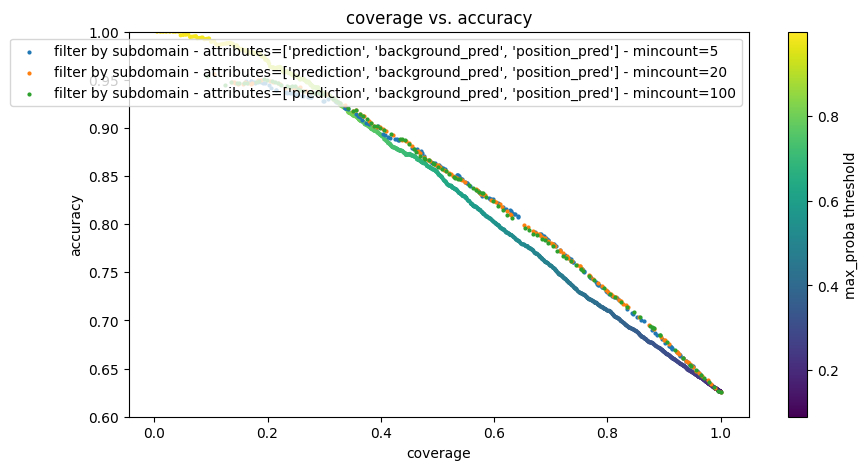

In [10]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(df_test['confidence'].min(), df_test['confidence'].max(), 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test.loc[idx_domain, 'correct'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, s=4, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='max_proba threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')

attributes = ['prediction', 'background_pred', 'position_pred']
for c in [5, 20, 100]:
    df_test = semantic_binning(df_calib, df_test, attributes, df_test['prediction'].unique(), min_count=c)

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes} - mincount={c}')
plt.legend(loc='upper right')
plt.ylim((0.6, 1))

['prediction', 'background_pred', 'position_pred']
152 calib subdomains
3142 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.786
ECE baseline: 0.029 ECE: 0.072

['prediction', 'background_pred', 'position_pred']
350 calib subdomains
1611 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.817
ECE baseline: 0.029 ECE: 0.038

['prediction', 'background_pred', 'position_pred']
545 calib subdomains
935 nan values (they appear because subdomains in test are not all included in train). Fallback to average for predicted class.
AUROC baseline: 0.810 AUROC subdomains: 0.829
ECE baseline: 0.029 ECE: 0.031



(0.6, 1.0)

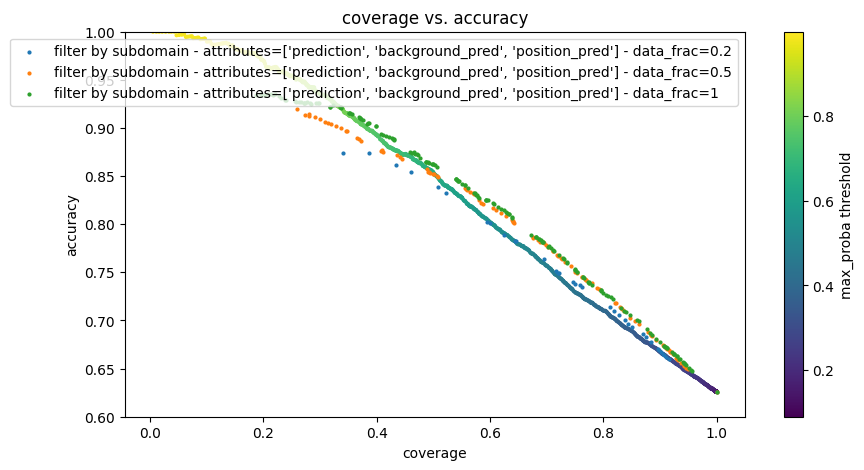

In [11]:
# baseline: max softmax
domain_cutoff_baseline = np.linspace(df_test['confidence'].min(), df_test['confidence'].max(), 1000)
coverage_baseline = np.zeros_like(domain_cutoff_baseline)
risk_baseline = np.zeros_like(domain_cutoff_baseline)
acc_baseline = np.zeros_like(domain_cutoff_baseline)
for i, cut in enumerate(domain_cutoff_baseline):
    idx_domain = df_test['confidence'] > cut
    coverage_baseline[i] = idx_domain.mean()
    acc_baseline[i] = df_test.loc[idx_domain, 'correct'].mean()

# plot
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))
ax1.set_title(f'coverage vs. accuracy')
sc = ax1.scatter(coverage_baseline, acc_baseline, s=4, c=domain_cutoff_baseline, cmap='viridis')
fig.colorbar(sc, ax=ax1, label='max_proba threshold')
ax1.set_xlabel('coverage')
ax1.set_ylabel('accuracy')


for calib_frac in [0.2, 0.5, 1]:
    if calib_frac == 1:
        df_calib_frac = df_calib
    else:
        df_calib_frac = train_test_split(df_calib, test_size=calib_frac, random_state=0, shuffle=True, stratify=df_calib['label'])[1]
    df_test = semantic_binning(df_calib_frac, df_test, ['prediction', 'background_pred', 'position_pred'], df_test['prediction'].unique(), min_count=3)

    coverage = np.zeros(len(df_test['subdomain_score'].unique()))
    accuracy = np.zeros(len(df_test['subdomain_score'].unique()))
    for i, cut in enumerate(sorted(df_test['subdomain_score'].unique(), reverse=True)):
        idx_domain = df_test['subdomain_score'] >= cut
        coverage[i] = idx_domain.mean()
        accuracy[i] = df_test[idx_domain]['correct'].mean()
    ax1.scatter(coverage, accuracy, s=4, label=f'filter by subdomain - attributes={attributes} - data_frac={calib_frac}')
plt.legend(loc='upper right')
plt.ylim((0.6, 1))

# Synthetic data

In [35]:
path_sd = path_huggingface + 'stabilityai/stable-diffusion-2-1'
# path_sd = path_huggingface + 'stabilityai/stable-diffusion-xl-base-1.0'

pipe = DiffusionPipeline.from_pretrained(str(path_sd), torch_dtype=torch.float16, revision='fp16', use_safetensors=True)

path_out_textual_inversion = Path('../results/textual_inversion/sd-2-1-base')
for path in path_out_textual_inversion.iterdir():
    pipe.load_textual_inversion(path / 'learned_embeds.safetensors')
pipe = pipe.to("cuda")

list_tokens = []
for t in pipe.tokenizer.added_tokens_decoder.values():
    if t.special == False:
        list_tokens.append(str(t))


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [54]:
list_tokens

['<001_Black_footed_Albatross>',
 '<002_Laysan_Albatross>',
 '<006_Least_Auklet>',
 '<008_Rhinoceros_Auklet>',
 '<007_Parakeet_Auklet>',
 '<005_Crested_Auklet>',
 '<003_Sooty_Albatross>',
 '<004_Groove_billed_Ani>']

In [64]:
list_tokens[3]

'<008_Rhinoceros_Auklet>'

  0%|          | 0/50 [00:00<?, ?it/s]

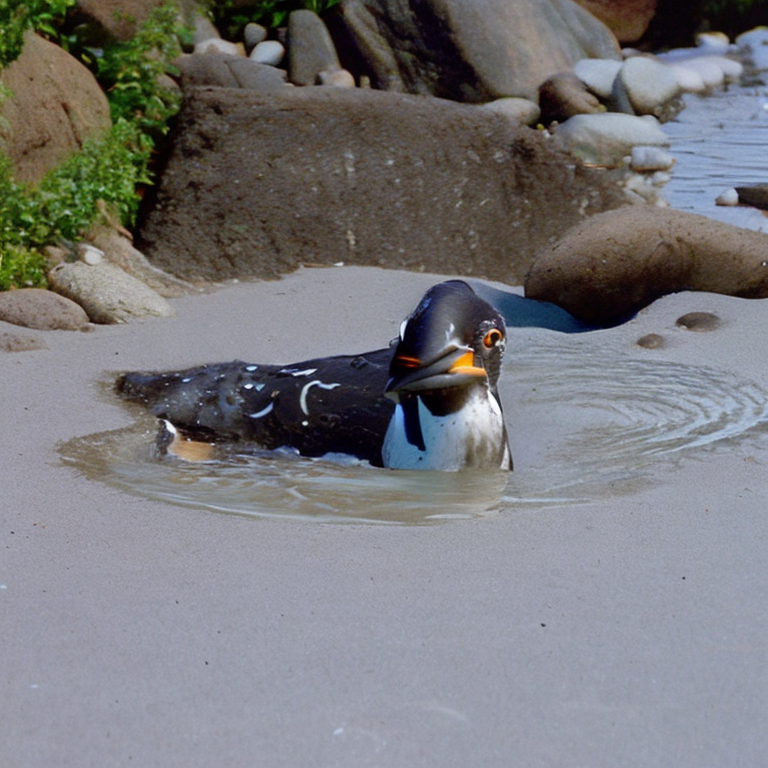

In [72]:
prompt = f"a high quality photo of a {list_tokens[3]} on the beach"
# prompt = f"a high quality photo of a Black footed Albatross on the beach"
# prompt = f"a high quality photo of a Rhinoceros Auklet on the beach"

# prompt = f"A photo of a Rhinoceros Auklet standing on a branch in a jungle"
# prompt="A photo of an astronaut in a jungle, detailed, 8k"
image = pipe(prompt).images[0]
image


In [73]:
pipe.scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.28.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "v_prediction",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [ ]:
path_huggingface = os.path.expandvars('$DSDIR/HuggingFace_Models/') 
path_pretrained = Path(os.path.expandvars('$WORK/MODELS'))
path_sd = str(path_pretrained / 'stabilityai--stable-diffusion-2-1-base')
path_data = Path(os.path.expandvars('$SCRATCH/CUB_200_2011/images'))
path_train_textual_inversion = Path('../results/img_cache/')
path_out_textual_inversion = Path('../results/textual_inversion/')

nb_images = 10

for subfolder in sorted(path_data.iterdir()):
    print(subfolder)

    (path_out_textual_inversion/subfolder.name).mkdir()
    path_train_textual_inversion.mkdir()
    for path_img in sorted((path_data / subfolder).iterdir())[:nb_images]:
        shutil.copy(path_img, path_train_textual_inversion)

    token = f'<{subfolder.name.replace(".", "_")}>'

    !accelerate", "launch", "textual_inversion.py",
        "--pretrained_model_name_or_path", str(path_sd),
        "--train_data_dir", str(path_train_textual_inversion),
        "--output_dir", str(path_out_textual_inversion/subfolder.name),
        "--placeholder_token", token,
        "--initializer_token", "bird",
        "--gradient_checkpointing",
        "--mixed_precision", "fp16",
        "--validation_prompt", f"A {token}.",
        "--num_validation_images", "4",
        "--validation_steps", "100"]